In [ ]:
!pip install pyspark matplotlib networkx

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("TFIDF-KMeans-Clustering").getOrCreate()

In [ ]:
# data = spark.read.option("header", "false").csv("/content/drive/MyDrive/tester.csv").toDF("tweets")
data = spark.read.option("header", "false").csv("/content/drive/MyDrive/init_data.csv").toDF("sentiment", "tweet_id", "date", "no_query", "username", "tweets").limit(100000)
data = data.na.fill("")

In [ ]:
from pyspark.ml.feature import Tokenizer, Word2Vec

tokenizer = Tokenizer(inputCol="tweets", outputCol="words")
wordsData = tokenizer.transform(data)

word2Vec = Word2Vec(vectorSize=100, minCount=0, inputCol="words", outputCol="features")
model = word2Vec.fit(wordsData)
result = model.transform(wordsData)

In [ ]:
from pyspark.sql.types import DoubleType
from pyspark.sql import functions as F
from pyspark.ml.feature import ElementwiseProduct
from pyspark.ml.linalg import DenseVector

unitVector = DenseVector([1.0] * 100)
dot_udf = F.udf(lambda x: float(DenseVector(x).dot(unitVector)), DoubleType())

# Calculate the dot product and cosine similarity
dotProduct = ElementwiseProduct(scalingVec=unitVector, inputCol="features", outputCol="dotProduct")
result = dotProduct.transform(result)

result = result.withColumn("cosineSimilarity", dot_udf("dotProduct"))

In [ ]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=69, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(result)
result = model.transform(result)

In [ ]:
result.show(n=20000)

+--------------------+--------------------+--------------------+--------------------+--------------------+-------+
|              tweets|               words|            features|          dotProduct|    cosineSimilarity|cluster|
+--------------------+--------------------+--------------------+--------------------+--------------------+-------+
|that's a bummer. ...|[that's, a, bumme...|[0.00427640587440...|[0.00427640587440...| 0.15394017434118723|     32|
|is upset that he ...|[is, upset, that,...|[0.01969721522288...|[0.01969721522288...|-0.00319397393104...|     28|
|@Kenichan I dived...|[@kenichan, i, di...|[0.00125642424666...|[0.00125642424666...|-0.02144577110146...|     35|
|my whole body fee...|[my, whole, body,...|[-0.0144832098390...|[-0.0144832098390...|-0.03955447242042283|     68|
|it's not behaving...|[it's, not, behav...|[0.00738418646352...|[0.00738418646352...| 0.35580161066440935|     50|
|@Kwesidei not the...|[@kwesidei, not, ...|[0.00829036880750...|[0.0082903688075

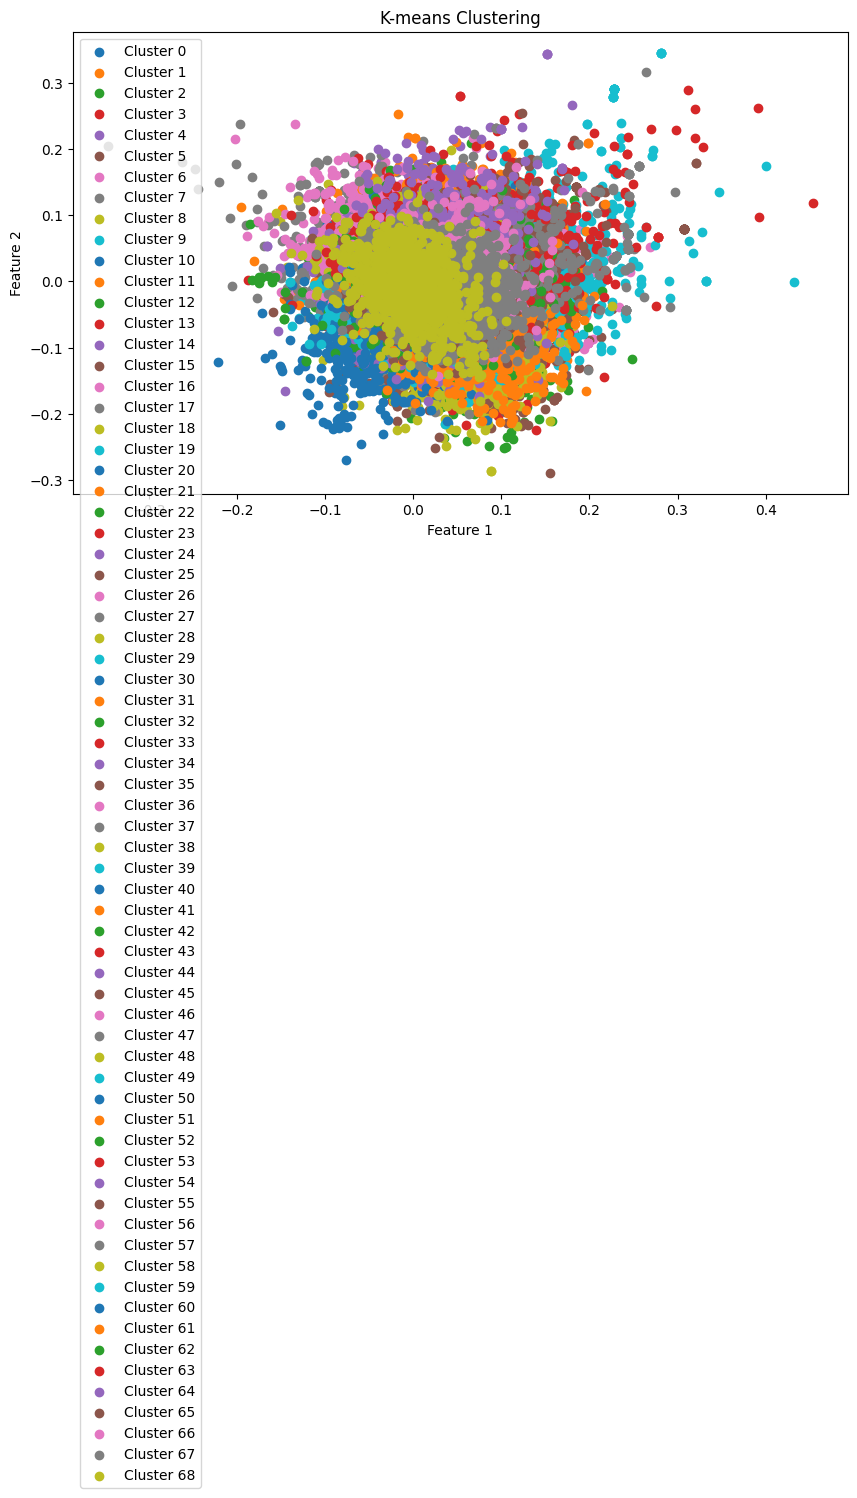

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Collect the necessary data to plot
local_result = result.select("features", "cluster").toPandas()

# Extract the X and Y coordinates for plotting (assuming vectorSize=2)
local_result["x"] = local_result["features"].apply(lambda v: v[0])
local_result["y"] = local_result["features"].apply(lambda v: v[1])

# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster_id in range(69):  # Adjust based on your actual number of clusters
    cluster_data = local_result[local_result["cluster"] == cluster_id]
    plt.scatter(cluster_data["x"], cluster_data["y"], label=f"Cluster {cluster_id}")

plt.title("K-means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [ ]:
import networkx as nx
from pyspark.sql.window import Window
from pyspark.sql.functions import desc

# Assuming result is the DataFrame obtained after K-means clustering
clusters = result.select("cluster").distinct().rdd.flatMap(lambda x: x).collect()

for cluster_id in clusters:
    # print(cluster_id)
    # Select tweets in the current cluster
    cluster_data = result.filter(result["cluster"] == cluster_id)

    # Extract tweet IDs and cosine similarities
    similarity_df = cluster_data.select("cosineSimilarity").withColumn("tweet_id", F.monotonically_increasing_id())
    windowSpec = Window.orderBy(desc("cosineSimilarity"))
    similarity_df = similarity_df.withColumn("rank", F.dense_rank().over(windowSpec))
    similarity_df = similarity_df.select("tweet_id", "cosineSimilarity")
        # .filter("rank <= 5")  # You can adjust the number of top similarities to show

    # Convert the Spark DataFrame to Pandas
    similarity_pd = similarity_df.toPandas()

    # Plot the similarity graph using networkx
    G = nx.Graph()

    # Add nodes
    for row in similarity_pd.itertuples():
        G.add_node(row.tweet_id, label=f"{row.tweet_id}\nSimilarity: {row.cosineSimilarity:.4f}")

    # Add edges
    for i in range(len(similarity_pd)):
        for j in range(i + 1, len(similarity_pd)):
            G.add_edge(similarity_pd.at[i, "tweet_id"], similarity_pd.at[j, "tweet_id"], weight=similarity_pd.at[i, "cosineSimilarity"])

    # Plot the graph
    pos = nx.spring_layout(G)  # You can use other layout algorithms as well
    labels = nx.get_edge_attributes(G, 'weight')
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]

    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(G, pos, node_size=100, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=8, font_color='black', font_family='sans-serif')
    # nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='red')

    plt.title(f"Similarity Graph - Cluster {cluster_id}")
    plt.show()


In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

# List to store silhouette scores for different k values
silhouette_scores = []

# Range of k values to try
k_values = range(60, 65)  # Adjust the range based on your requirements

for k in k_values:
    # Perform K-means clustering for the current k value
    kmeans = KMeans(k=k, featuresCol="features", predictionCol="cluster")
    model = kmeans.fit(result)
    clustered_data = model.transform(result)

    # Evaluate the clustering using the Silhouette score
    evaluator = ClusteringEvaluator(predictionCol="cluster")  # Specify the correct predictionCol
    silhouette_score = evaluator.evaluate(clustered_data)
    silhouette_scores.append(silhouette_score)
    print(k, silhouette_score)

60 0.00860210980390734
61 0.01026666650420143
62 0.010411652599648052
63 0.01006327008507643
64 0.006488335977609377
65 0.01548334011471096
66 0.012385003912966663
67 0.006657044203060385
68 0.009840858130270483
69 0.010698722114494122


NameError: ignored

In [ ]:
k_values = range(2, 75)  # Adjust the range based on your requirements

for k in k_values:
    # Perform K-means clustering for the current k value
    kmeans = KMeans(k=k, featuresCol="features", predictionCol="cluster")
    model = kmeans.fit(result)
    clustered_data = model.transform(result)

    # Evaluate the clustering using the Silhouette score
    evaluator = ClusteringEvaluator(predictionCol="cluster")  # Specify the correct predictionCol
    silhouette_score = evaluator.evaluate(clustered_data)
    silhouette_scores.append(silhouette_score)
    print(k, silhouette_score)

2 0.1329886090722786
3 0.1355175668580695
4 0.12977809083712843
5 0.10312231304203975
6 0.09167487242130681
7 0.07567271738685732
8 0.0491323925041291
9 0.017430564197981765
10 0.031240492836745376
11 0.0217588753669502
12 0.013551013364902094
13 0.01994876340055835
14 0.016039916894888942
15 0.012031705438467459
16 0.041174067359687726
17 0.013565484545942638
18 0.024645088846046305
19 0.02468577592914291
20 0.013097488884151515
21 0.026455256039693665
22 0.020551940226733765
23 0.025348485945528514
24 0.01904150140638394
25 0.022454566943454376
26 0.02561957773947641
27 0.017566033929203903
28 0.014377014140621109
29 0.0152934644747334
30 0.02158563559029504
31 0.013642188099957191
32 0.006483792469832867
33 0.016871258022713113
34 0.010516432384718772
35 0.014342182788103439
36 0.0174649592022149
37 0.013952914957606772
38 0.011955283344223928
39 0.014643617277925822
40 0.01838997298342445
41 0.018256957946129356
42 0.014477871151533931
43 0.015457743281947926
44 0.00092311074382458

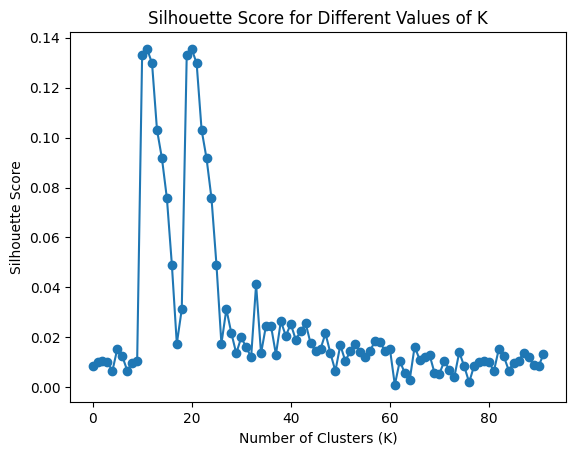

In [ ]:
import matplotlib.pyplot as plt

# Find the optimal k value based on the maximum silhouette score
# optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]

# Plot the silhouette scores
plt.plot(range(len(silhouette_scores)), silhouette_scores, marker='o')
plt.title('Silhouette Score for Different Values of K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

# print(f"Optimal K value: {optimal_k}")